In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [73]:
# build the dataset 

block_size = 3 # context length: how many chars do we want to take to predict the next one
X, Y = [] , [] 

for w in words:
    
#     print(w)
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
#         print(f'X: {X}')

X = torch.tensor(X)
Y = torch.tensor(Y)

In [101]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # Training split
Xdev, Ydev = build_dataset(words[n1:n2]) # Validation split
Xte, Yte = build_dataset(words[n2:]) # Test split 

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [72]:
# For the first 5 words: 
# emma
# ... ---> e
# ..e ---> m
# .em ---> m
# emm ---> a
# mma ---> .
# olivia
# ... ---> o
# ..o ---> l
# .ol ---> i
# oli ---> v
# liv ---> i
# ivi ---> a
# via ---> .
# ava
# ... ---> a
# ..a ---> v
# .av ---> a
# ava ---> .
# isabella
# ... ---> i
# ..i ---> s
# .is ---> a
# isa ---> b
# sab ---> e
# abe ---> l
# bel ---> l
# ell ---> a
# lla ---> .
# sophia
# ... ---> s
# ..s ---> o
# .so ---> p
# sop ---> h
# oph ---> i
# phi ---> a
# hia ---> .

In [74]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [16]:
C = torch.randn((27,2)) # Lookup table: 27 chars --> 2 dimensions

In [17]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [33]:
W1 = torch.randn((6,100)) # 6 (3x2) inputs to the layer, 100 neurons as an example 
b1 = torch.randn(100)

In [34]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # -1 will make PyTorch infer the shape based on the other dimension
# emb.view(32,6) is the same operation as:
# 1. torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim =1)
# 2. torch.cat(torch.unbind(emb,1),dim = 1)  # INEFFICIENT: Creates new memory 
# But much faster 

In [36]:
W2 = torch.randn((100,27)) # 100 inputs to the layer, 27 outputs, since 27 possible characters
b2 = torch.randn(27)

In [37]:
logits = h @ W2 + b2

In [39]:
counts = logits.exp()
probs = counts/counts.sum(1, keepdims= True)

In [118]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [195]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g, requires_grad = True) # 10 dimensinal embeddings
W1 = torch.randn((30, 200), generator=g, requires_grad = True) # 3 x 10 inputs = 30 
b1 = torch.randn(200, generator=g, requires_grad = True)
W2 = torch.randn((200, 27), generator=g, requires_grad = True)
b2 = torch.randn(27, generator=g, requires_grad = True)
parameters = [C, W1, b1, W2, b2]

In [196]:
sum(p.nelement() for p in parameters)

11897

In [197]:
lre = torch.linspace(-3,0,1000)
lrs = 10 ** lre

In [198]:
lri = []
lossi = []
stepi = [] 

In [204]:
for i in range(200_000):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[Xtr[ix]] # 32 x 3 x 2
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32 x 100
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

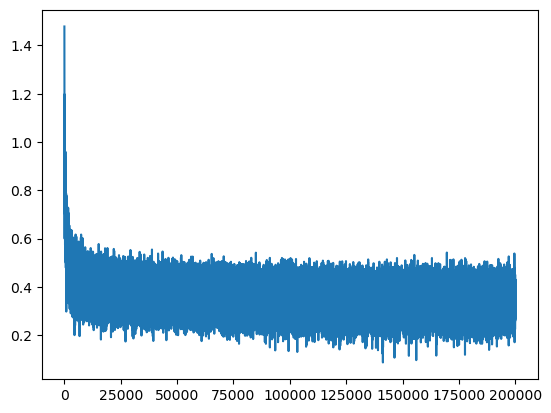

In [200]:
plt.plot(stepi,lossi)

In [205]:
# Evaluate the model on the Dev set 
emb = C[Xtr] # 32 x 3 x 2
h = torch.tanh(emb.view(-1,30)@W1 +b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss 

tensor(2.1686, grad_fn=<NllLossBackward0>)

In [206]:
# Evaluate the model on the Dev set 
emb = C[Xdev] # 32 x 3 x 2
h = torch.tanh(emb.view(-1,30)@W1 +b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss 

tensor(2.2522, grad_fn=<NllLossBackward0>)

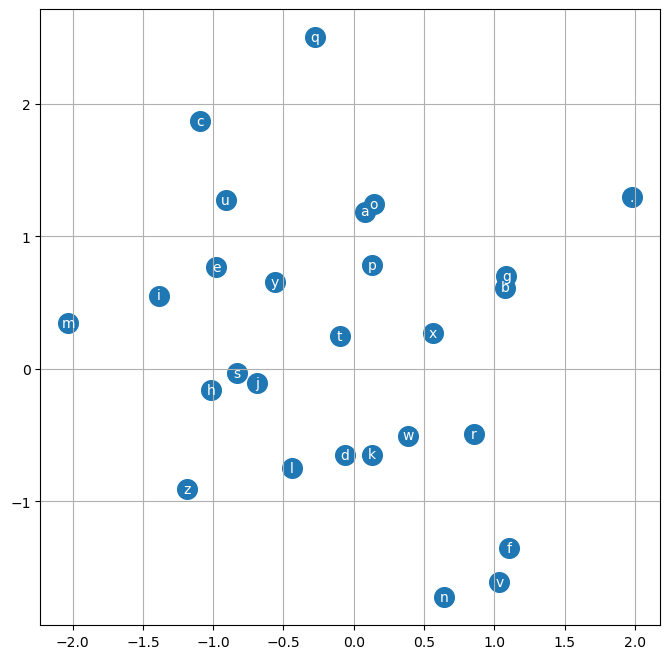

In [209]:
# Visualize the dimensions 0 and 1 of the embedding matrix
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center" , color = "white")

plt.grid('minor')

In [210]:
# Sample from the model and generate names 
g = torch.Generator().manual_seed(2147483647 + 10) 

for _ in range(20):
    
    out = []
    context = [0] * block_size # init with all "..."
    while True: 
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits , dim = 1)
        ix = torch.multinomial(probs, num_samples = 1 , generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0: 
            break
     
    print("".join(itos[i] for i in out))

carlah.
quille.
khi.
mis.
reigh.
skaessa.
jazzmen.
dmeryst.
kaelian.
kasiah.
maiivan.
lege.
dham.
prin.
quintis.
lil.
alian.
quinte.
maijarystiah.
eilias.
